In [174]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import seaborn as sns
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [175]:
companies = [
    "NFLX", "TSLA", "ORCL", "CSCO", "CRM", "ADBE", "SNPS", "INTC", "AAPL", "MSFT", "GOOGL", "META", "AMZN",
    "QCOM", "TXN", "AMAT", "NOW", "RNG", "HPE", "NVDA", "AMD", "IBM", "INTU", "LRCX", "MU", "ADSK", "PLTR", 
    "ZS", "PANW", "SNOW", "DDOG", "CRWD", "V", "MA", "C", "JPM", "WFC", "TROW", "SCHW", "CME", "MSCI", 
    "PYPL", "SQ", "SHOP", "AXP", "GS", "MS", "SPGI", "BLK", "BAC", "NKE", "LULU", "TJX", "COST", "HD", "LOW",
    "TGT", "WMT", "BBY", "F", "GM", "DE", "RCL", "UAL", "DAL", "AAL", "BKNG", "MAR", "HLT", "JNJ", "PFE", 
    "MRK", "AMGN", "ABBV", "CVS", "GSK", "AZN", "BMY", "LLY", "GILD", "MRNA", "REGN", "TMO", "ISRG", "SYK", 
    "BDX", "DHR", "KO", "PEP", "PG", "CLX", "CAG", "SJM", "CPB", "DIS", "EA", "MO", "CL", "EL", "KHC", 
    "UL", "NSRGY", "COTY", "MCD", "YUM", "SBUX", "DASH", "WBA", "XOM", "CVX", "SLB", "OXY", "PXD", "COP", 
    "BKR", "VLO", "PSX", "APD", "LIN", "DOW", "DD", "SHW", "PPG", "NOC", "LMT", "GD", "RTX", "BA", "GE", 
    "CAT", "MMM", "HON", "ITW", "EMR", "DHR", "UNH", "CI", "HUM", "ANTM", "CNC"
]


In [188]:
data = pd.DataFrame()
target_classification = pd.DataFrame()

In [177]:
def remove_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]

In [178]:
def scale_data(uncscaled_data):
       price_columns = ['Open', 'High', 'Low', 'Close']
       technical_indicators = ['SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'MACD', 'MACD_signal', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']
       volume_column = 'Volume'
       
       for col in price_columns:
              uncscaled_data = remove_outliers(uncscaled_data, col)
       
       min_max_scaler = MinMaxScaler()
       standard_scaler = StandardScaler()

       uncscaled_data[price_columns] = standard_scaler.fit_transform(uncscaled_data[price_columns])

       uncscaled_data[volume_column] = np.log1p(uncscaled_data[volume_column])  
       uncscaled_data[[volume_column]] = standard_scaler.fit_transform(uncscaled_data[[volume_column]])

       uncscaled_data[technical_indicators] = standard_scaler.fit_transform(uncscaled_data[technical_indicators])              #Chnaged to minmax scaler from standard

       return uncscaled_data



In [179]:
def calculate_tech_ind(curr, data):

    data['SMA15'] = ta.sma(curr['Close'], length=15)  # Simple Moving Average
    data['EMA5'] = ta.ema(curr['Close'], length=5)    # Exponential Moving Average
    data['RSI15'] = ta.rsi(curr['Close'], length=15)  # Relative Strength Index

    # Bollinger Bands: Measures volatility with a moving average and standard deviations
    data['BB_upper'], data['BB_lower'] = ta.bbands(curr['Close'], length=56, std=2).iloc[:, [0, 2]].T.values

    # MACD and Signal Line: Trend-following momentum indicator
    data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values

    # On-Balance Volume: Volume-based trend indicator
    data['OBV'] = ta.obv(curr['Close'], curr['Volume'])

    # ADX (Average Directional Index): Measures trend strength
    data['ADX'] = ta.adx(curr['High'], curr['Low'], curr['Close']).iloc[:, 0]

    # Aroon Oscillator: Identifies trend direction and strength
    data['Aroon_Up'], data['Aroon_Down'] = ta.aroon(curr['High'], curr['Low']).iloc[:, [0, 1]].T.values
    
    uncleaned_data = pd.concat([curr, data], axis = 0)

    uncleaned_data = uncleaned_data.iloc[14:, :]

    uncleaned_data.fillna(method='ffill', inplace=True)

    uncleaned_data.fillna(method='bfill', inplace=True)

    scaled_data = scale_data(uncleaned_data)

    #result_df = final_pcas(scaled_data)

    return scaled_data

In [ ]:
for i in companies:
    try:

        curr = yf.download(i, period="max")

        curr = curr.reset_index()

        curr.columns = [col[0] for col in curr.columns]

        curr.drop(columns=['Date'], inplace=True)
        empty_data = pd.DataFrame()
        result_df = calculate_tech_ind(curr, empty_data)
        data = pd.concat([data, result_df], ignore_index=True)

    except Exception as e:
        print(e, i)

EMR


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_38560\2595796236.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


DHR


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_38560\2595796236.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


UNH


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_38560\2595796236.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


CI


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_38560\2595796236.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values
[*********************100%***********************]  1 of 1 completed

1 Failed download:
['ANTM']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')


HUM
'NoneType' object has no attribute 'iloc' ANTM


[*********************100%***********************]  1 of 1 completed
C:\Users\Nishc\AppData\Local\Temp\ipykernel_38560\2595796236.py:11: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  data['MACD'], data['MACD_signal'] = ta.macd(curr['Close']).iloc[:, [0, 1]].T.values


CNC


In [151]:
scaled_data = data

In [152]:
def print_column_ranges(data):
    for col in data.columns:
        col_min = data[col].min()
        col_max = data[col].max()
        col_range = col_max - col_min
        print(f"{col}: Min = {col_min}, Max = {col_max}, Range = {col_range}")

print_column_ranges(data)


Adj Close: Min = 0.0015667451079934835, Max = 4715.0, Range = 4714.998433254892
Close: Min = -3.110162698763613, Max = 3.4874372067256494, Range = 6.597599905489263
High: Min = -3.0793390770817335, Max = 3.5592350111802666, Range = 6.638574088262001
Low: Min = -3.0754512710766657, Max = 3.481155405715129, Range = 6.5566066767917945
Open: Min = -3.079132195511268, Max = 3.834453850541739, Range = 6.913586046053007
Volume: Min = -28.20148166433643, Max = 9.743928853796808, Range = 37.94541051813324
SMA15: Min = -3.5291134044725507, Max = 9.738713550949035, Range = 13.267826955421585
EMA5: Min = -3.6057521969223325, Max = 9.741758437838033, Range = 13.347510634760365
RSI15: Min = -5.32359583049079, Max = 5.115537992674431, Range = 10.439133823165221
BB_upper: Min = -3.4455641171804463, Max = 10.5243958292596, Range = 13.969959946440046
BB_lower: Min = -2.894946079012661, Max = 9.676511839993143, Range = 12.571457919005804
MACD: Min = -29.8467795668196, Max = 18.02536483930565, Range = 47.

In [135]:
scaled_data.shape

(2447926, 17)

In [191]:
target_reg = scaled_data['Close']
target_classification = (scaled_data['Close'].shift(-1) > scaled_data['Close']).astype(int)

In [184]:
input = scaled_data.drop(columns=['Low', 'Open','SMA15', 'BB_lower', 'BB_upper', 'Adj Close', 'Close', 'OBV'])

In [192]:
print(input.shape)
print(target_classification.shape)

(2447926, 9)
(2447926,)


In [156]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(input, target_reg, test_size=0.2, random_state=42)

In [193]:
X_train_cal, X_test_cal, y_train_cal, y_test_cal = train_test_split(input, target_classification, test_size=0.2, random_state=42)

In [ ]:
print(X_train_reg.shape, y_train_reg.shape)
print(X_train_cal.shape, y_train_cal.shape)

(1958340, 9) (1958340,)
(1958340, 9) (1958340,)


In [159]:
def final_pcas(data):
       feature_columns = ['Open', 'High', 'Low', 'SMA15', 'EMA5',
              'RSI15', 'BB_upper', 'BB_lower', 'OBV', 'ADX',
              'Aroon_Up', 'Aroon_Down']

       X = data[feature_columns]

       pca = PCA(n_components=8)  
       X_pca = pca.fit_transform(X)

       explained_variance = pca.explained_variance_ratio_
       cumulative_variance = np.cumsum(explained_variance)


       n_components_to_keep = np.argmax(cumulative_variance >= 0.90) 
       pca_final = PCA(n_components=n_components_to_keep)
       X_final = pca_final.fit_transform(X)

       pca_columns = [f'PC{i+1}' for i in range(n_components_to_keep)]
       pca_df = pd.DataFrame(data=X_final, columns=pca_columns)
       data = pd.DataFrame(data=data, columns=['MACD', 'MACD_signal'])                                   #Cost was removed from here
       result_df = pd.concat([data.reset_index(drop=True), pca_df.reset_index(drop=True)], axis=1)

       return result_df


In [ ]:
#data = final_pcas(data)

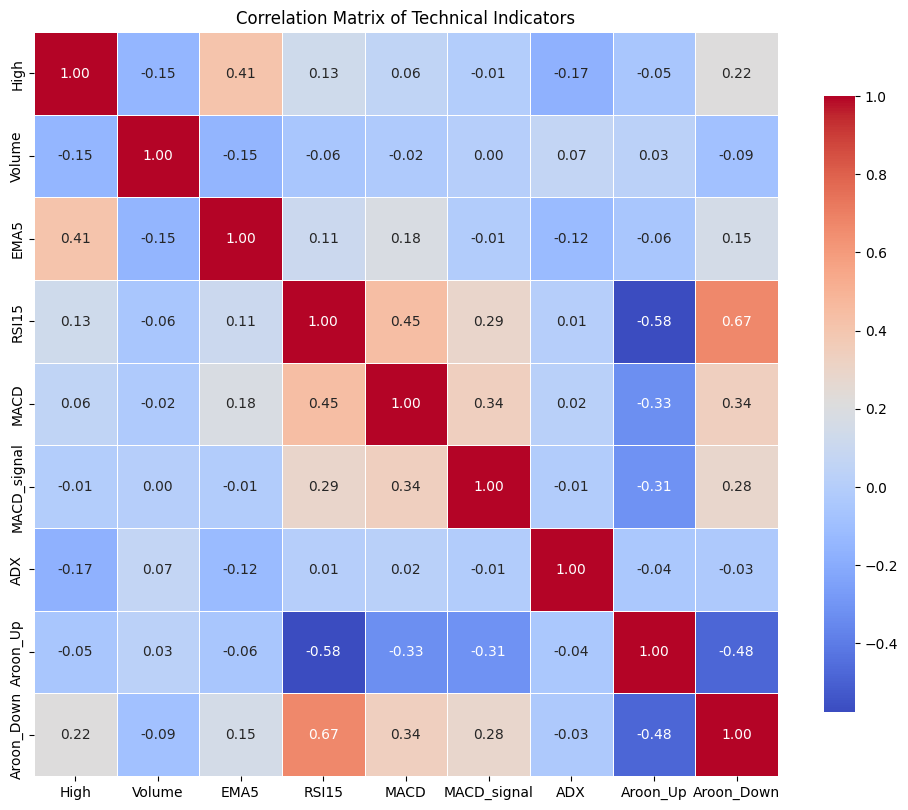

In [194]:
correlation_matrix = input.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
            square=True, cbar_kws={"shrink": .8}, linewidths=.5)

# Title and show the plot
plt.title('Correlation Matrix of Technical Indicators')
plt.show()


In [161]:
# Train XGBoost
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model.fit(X_train_reg, y_train_reg)

# Get feature importance scores
feature_importance = xgb_model.feature_importances_
important_features = X_train_reg.columns[feature_importance > 0.01]
print(feature_importance, important_features)

[9.9817508e-01 7.4674812e-05 4.3788255e-04 3.1011007e-04 3.2252882e-04
 1.1105625e-04 1.4183344e-04 5.5305565e-05 3.7156325e-04] Index(['High'], dtype='object')


In [162]:
model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train_reg, y_train_reg)

# Predict on the test set
y_pred = model.predict(X_test_reg)

# Evaluate the model
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mse)

print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
r2 = r2_score(y_test_reg, y_pred)
print(f'R² Score: {r2}')

Mean Squared Error (MSE): 0.0006059737087139056
Root Mean Squared Error (RMSE): 0.024616533239144492
R² Score: 0.999368230545666


In [163]:
kf = KFold(n_splits=100, shuffle=True, random_state=42)
mse_scores = []
rmse_scores = []
r2_scores = []

for train_index, test_index in kf.split(X_train_reg):
    X_train, X_val = X_train_reg.iloc[train_index], X_train_reg.iloc[test_index]
    y_train, y_val = y_train_reg.iloc[train_index], y_train_reg.iloc[test_index]
    
    model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_val, y_pred)
    
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)


# Print average scores
print(f'Average MSE: {np.mean(mse_scores)}')
print(f'Average RMSE: {np.mean(rmse_scores)}')
print(f'Average R² Score: {np.mean(r2_scores)}')

Average MSE: 0.0006019735518684816
Average RMSE: 0.02448179108959996
Average R² Score: 0.9993715143318639


In [164]:
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

param_grid = {
    'n_estimators': [5, 10, 20, 25, 30, 35, 40],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 10, 100]  # L2 regularization
}

grid_search = RandomizedSearchCV(estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
                           param_distributions=param_grid,
                           scoring='r2',
                           cv=15,
                           verbose=1)

grid_search.fit(X_train_reg, y_train_reg)
print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_reg)
mse = mean_squared_error(y_test_reg, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_reg, y_pred)
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R² Score: {r2}')

Fitting 15 folds for each of 10 candidates, totalling 150 fits
Best Parameters: {'subsample': 0.8, 'reg_lambda': 100, 'reg_alpha': 0.1, 'n_estimators': 40, 'max_depth': 5, 'learning_rate': 0.2, 'colsample_bytree': 0.8}
Mean Squared Error (MSE): 0.0008519413654358332
Root Mean Squared Error (RMSE): 0.029188034627837367
R² Score: 0.9991117922711396


In [165]:
type(best_model)

xgboost.sklearn.XGBRegressor

In [166]:
from joblib import dump

# Save the model
dump(best_model, 'model_reg.joblib')

['model_reg.joblib']

-----------
Classifier
-----------

In [171]:
model_c = xgb.XGBClassifier(random_state=42)
model_c.fit(X_train_cal, y_train_cal)
y_pred = model_c.predict(X_test_cal)

accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.7731246400019608


-----------
Regressor
----------

In [170]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
accuracy_scores = []

for train_index, val_index in kf.split(X_train_cal):
    X_train, X_val = X_train_cal.iloc[train_index], X_train_cal.iloc[val_index]
    y_train, y_val = y_train_cal.iloc[train_index], y_train_cal.iloc[val_index]

    model_c = xgb.XGBClassifier(random_state=42)
    model_c.fit(X_train, y_train)
    
    y_pred = model_c.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    accuracy_scores.append(accuracy)

print(f'Average Accuracy: {np.mean(accuracy_scores)}')

Average Accuracy: 0.7730567725726891


In [92]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],  # L1 regularization
    'reg_lambda': [1, 10, 100]  # L2 regularization
}

grid_search = GridSearchCV(estimator=xgb.XGBClassifier(random_state=42),
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=1)

grid_search.fit(X_train_cal, y_train_cal)
print(f"Best Parameters: {grid_search.best_params_}")

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_cal)
accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')


Fitting 5 folds for each of 2187 candidates, totalling 10935 fits
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'reg_alpha': 1, 'reg_lambda': 1, 'subsample': 0.8}
Accuracy: 0.7311960825219682


In [169]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_cal)
accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [94]:
dump(best_model, 'best_model_grid_cal_max.joblib')

['best_model_grid_cal_max.joblib']

-------
Deep Learning - Regressor
-------

In [95]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_reg.shape[1],)), 
    layers.Dense(32, activation='relu'), 
    layers.Dense(1)  
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train_reg, y_train_reg, epochs=100, batch_size=32, validation_split=0.2)

y_pred = model.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, y_pred)
print(f'Mean Squared Error: {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

results = pd.DataFrame({
    'Actual': y_test_reg,
    'Predicted': y_pred.flatten()  
})

print(results.head())


c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/100
43620/43620 [==============================] - 221s 5ms/step - loss: 66.6901 - val_loss: 0.9188
Epoch 2/100
43620/43620 [==============================] - 187s 4ms/step - loss: 0.9118 - val_loss: 0.8198
Epoch 3/100
43620/43620 [==============================] - 195s 4ms/step - loss: 0.8909 - val_loss: 0.9134
Epoch 4/100
43620/43620 [==============================] - 188s 4ms/step - loss: 0.8507 - val_loss: 1.0969
Epoch 5/100
43620/43620 [==============================] - 191s 4ms/step - loss: 0.8388 - val_loss: 0.8355
Epoch 6/100
43620/43620 [==============================] - 199s 5ms/step - loss: 0.8215 - val_loss: 0.8874
Epoch 7/100
43620/43620 [==============================] - 197s 5ms/step - loss: 0.8089 - val_loss: 0.7095
Epoch 8/100
43620/43620 [==============================] - 204s 5ms/step - loss: 0.7915 - val_loss: 0.7432
Epoch 9/100
43620/43620 [==============================] - 205s 5ms/step - loss: 0.7735 - val_loss: 0.9114
Epoch 10/100
43620/43620 [==========

-----
Deep Learning - Classification
-----

In [195]:
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(X_train_cal.shape[1],)), 
    layers.Dense(32, activation='relu'), 
    layers.Dense(1)  
])

with tf.device('/GPU:0'):
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

model.fit(X_train_cal, y_train_cal, epochs=10, batch_size=32, validation_split=0.2)

y_pred = (model.predict(X_test_cal) > 0.5).astype("int32")
accuracy = accuracy_score(y_test_cal, y_pred)
print(f'Accuracy: {accuracy}')

c:\Users\Nishc\anaconda3\envs\TensorFlow_ENV\lib\site-packages\keras\engine\data_adapter.py:1699: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  return t[start:end]


Epoch 1/10
48959/48959 [==============================] - 203s 4ms/step - loss: 0.1218 - accuracy: 0.7688 - val_loss: 0.1201 - val_accuracy: 0.7723
Epoch 2/10
48959/48959 [==============================] - 264s 5ms/step - loss: 0.1202 - accuracy: 0.7701 - val_loss: 0.1199 - val_accuracy: 0.7720
Epoch 3/10
48959/48959 [==============================] - 237s 5ms/step - loss: 0.1200 - accuracy: 0.7703 - val_loss: 0.1200 - val_accuracy: 0.7718
Epoch 4/10
48959/48959 [==============================] - 166s 3ms/step - loss: 0.1198 - accuracy: 0.7706 - val_loss: 0.1199 - val_accuracy: 0.7680
Epoch 5/10
48959/48959 [==============================] - 167s 3ms/step - loss: 0.1197 - accuracy: 0.7711 - val_loss: 0.1196 - val_accuracy: 0.7709
Epoch 6/10
48959/48959 [==============================] - 157s 3ms/step - loss: 0.1197 - accuracy: 0.7708 - val_loss: 0.1197 - val_accuracy: 0.7705
Epoch 7/10
48959/48959 [==============================] - 157s 3ms/step - loss: 0.1196 - accuracy: 0.7715 - val_

In [ ]:
X_train_cal_pca = final_pcas(X_train_cal)
X_test_cal_pca = final_pcas(X_test_cal)

In [196]:
from keras import layers, models
from keras_tuner import RandomSearch

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32),
                           activation='relu', input_shape=(X_train_cal.shape[1],)))
    model.add(layers.Dense(units=hp.Int('units2', min_value=16, max_value=48, step=16),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=5,
                     executions_per_trial=1,
                     directory='my_dir',
                     project_name='helloworld')

tuner.search(X_train_cal, y_train_cal, epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]


Trial 5 Complete [00h 12m 31s]
val_accuracy: 0.7724220752716064

Best val_accuracy So Far: 0.7729301452636719
Total elapsed time: 01h 06m 05s


In [ ]:
from keras import layers, models
from keras_tuner import RandomSearch

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32),
                           activation='relu', input_shape=(X_train_cal_pca.shape[1],)))
    model.add(layers.Dense(units=hp.Int('units2', min_value=16, max_value=48, step=16),
                           activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

tuner = RandomSearch(build_model,
                     objective='val_accuracy',
                     max_trials=10,
                     executions_per_trial=1,
                     directory='my_dir_pca',
                     project_name='helloworld')

tuner.search(X_train_cal_pca, y_train_cal, epochs=5, validation_split=0.2)
best_model = tuner.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 02m 43s]
val_accuracy: 0.719045877456665

Best val_accuracy So Far: 0.719045877456665
Total elapsed time: 00h 27m 21s
